## Assignment 6
----

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Functions / Classes
-----

In [2]:
def Clenshaw_Curtis(M, domain = [-1, 1]):
    """
    Calculates M Clenshaw-Curtis nodes on the specified interval
    NOTE give values 2**(n) + 1 for sequence of n = 1,2,... for nested nodes
    """
    nodes = []
    dom_len = domain[1]-domain[0]
    dom_shift = domain[0]

    nodes = dom_len/2*(np.cos(np.arange(M)*np.pi/(M-1)) + 1) + domain[0]
    
    return nodes

def Lagrange(Z, Z_vals, k):
    """
    Lagrange k-th polynomial in the point Z and given points Z_val
    """
    res = 1

    for Z_i in Z_vals:
        if Z_i == Z_vals[k]:
            continue
        res *= (Z - Z_i)/(Z_vals[k] - Z_i)

    return res

def residual(w, N, kappa, dx, boundary):
    """
    Residual used in Newton method
    """
    res_val = []

    for k in range(N):
        # boundary cases
        if k == 0:
            res_val.append(w[k] - boundary[0])
        elif k == N-1:
            res_val.append(w[k] - boundary[1])

        # other case
        else:
            res_val.append((w[k+1]**2-w[k-1]**2)/(4*dx) - kappa*(w[k+1]-2*w[k] + w[k-1])/(dx**2))

    return res_val

def System_solver(N, domain, boundary, kappa, steps = 50, res_tol = 10**(-8), update_tol = 10**(-8)):
    """
    Newton solver for Burgers equation
    Python version of burgers_steady_viscous.m from 
    https://people.sc.fsu.edu/~jburkardt/m_src/burgers_steady_viscous/burgers_steady_viscous.html 
    """
    # init function guess -> line between boundary conditions
    w = np.linspace(boundary[0], boundary[1], N)
    
    # distance between points in x-direction
    dx = (domain[1]-domain[0])/(N-1)
    
    # set up Jacobian
    Jacobian = np.zeros((N,N))
    
    # current step count
    step = 0
    while step < steps:
        # get update of residual values
        res_value = residual(w, N, kappa, dx, boundary)

        # see if converged enough in terms of residual
        if np.linalg.norm(res_value, np.inf) < res_tol:
            #print('f conv', step)
            break

        # get update of Jacobian
        for i in range(N):
            # boundary cases
            if i == 0 or i == N-1:
                Jacobian[i][i] = 1
            else:
                Jacobian[i][i] = 2*kappa/(dx**2)
                Jacobian[i][i-1] = -w[i-1]/(2*dx) - kappa/(dx**2)
                Jacobian[i][i+1] = w[i+1]/(2*dx) - kappa/(dx**2)
    
        # get Newton update
        dw = np.linalg.solve(Jacobian, res_value)

        # see if converged enough in terms of step (or update) size
        if np.linalg.norm(dw, np.inf) < update_tol*(np.linalg.norm(w, np.inf)+1):
            #print('update size convergence', step)
            break

        # update estimate
        w = w - dw

        # increment step count
        step += 1

    return w

class Stoch_Collocation():
    def __init__(self):

        self.Newton_solve_vals = {'test': None}

    def stoch_colloctation(self, N, M, kappa, res_tol=10**(-8), update_tol=10**(-8)):
        
        # test if values can be reused from previous runs
        if self.Newton_solve_vals['test'] == None:
            self.Newton_solve_vals['test'] = N
        # if not reset dictionary
        elif self.Newton_solve_vals['test'] != N:
            self.Newton_solve_vals = {'test': N}

        # get the CC nodes
        nodes = Clenshaw_Curtis(M, [0.05, 0.35])
        # init list for the approximations
        approx = [0 for i in range(N)]
        # dictionary of the Lagrange polynomial values -> can be re-used
        Lagrange_vals = {}

        # Get Lagrange values + `exact' solutions for CC-nodes
        for j, z in enumerate(nodes):
            Lagrange_vals[j] = Lagrange(kappa, nodes, j)

            # NOTE only depends on nodes z and N
            if type(self.Newton_solve_vals.get(z, -1)) == int:
                self.Newton_solve_vals[z] = System_solver(N, [-1, 1], [1, -1], z, steps = 50, res_tol=res_tol, update_tol=update_tol)

        # calculate approximation
        for i in range(N):
            for j, z in enumerate(nodes):
                approx[i] += self.Newton_solve_vals[z][i]*Lagrange_vals[j]

        return approx

    def Lagrange_func_int(self, M, N=251, x_ind : list = False):
        """
        `Exact' expectation for the SC-estimate 
        x_ind list of indices for which to compute true mean
        -> indices correspond to the N x-values on [-1,1]
        """
        # test if values can be reused from previous runs
        if self.Newton_solve_vals['test'] == None:
            self.Newton_solve_vals['test'] = N
        # if not reset dictionary
        elif self.Newton_solve_vals['test'] != N:
            self.Newton_solve_vals = {'test': N}
        
        Z_vals, weights = np.polynomial.legendre.leggauss(int((M+1)/2))

        CC_points = Clenshaw_Curtis(M, [0.05, 0.35])

        for k, z in enumerate(CC_points):
            if type(self.Newton_solve_vals.get(z, -1)) == int:
                self.Newton_solve_vals[z] = System_solver(N, [-1, 1], [1, -1], z)
        
        first_moment = []

        if x_ind == False:
            loop_indices = range(N)
        else:
            loop_indices = x_ind
        
        for x_ind in loop_indices:
            m1 = 0
            for i,z in enumerate(Z_vals):
                for k in range(M):
                    m1 += self.Newton_solve_vals[CC_points[k]][x_ind]*Lagrange(0.15*z+0.2, CC_points, k)*weights[i]

            # why 0.5 well we get from change of variable from (a,b) -> (-1, 1) a factor (b-a)/2
            # however the original integral also had a density that is 1/(b-a) thus only 1/2 remains.
            first_moment.append(0.5*m1)

        return first_moment

def bootstrap(B: int, data: list, stat, args=[] ):
    """
    Description
    -----------
    Function that creates B bootstraps from data and calculates stat for these values

    Parameters
    ---------
    B: int
        Number of bootstrap samples to be made
    
    data: list
        data from which bootstrap samples are generated

    Returns
    -------
    bs_stat: list
    """

    n = len(data)
    bs_stat = []
    for i in range(B):
        bs_data = np.random.choice(data, n)
        bs_stat.append(stat(bs_data, *args))

    return bs_stat

def bootstrap_CI(B, data, stat, args=[], alpha=0.025):
    """
    Calculates the bootstrap CI of level 1 - 2alpha
    """
    bs_vals = bootstrap(B, data, stat, args)
    
    quants = np.quantile(bs_vals, [alpha, 1-alpha])
    CI = [2*stat(data, *args) - quants[1], 2*stat(data, *args) - quants[0]]
    
    return CI

### Mean/Variance
--------

In [3]:
# number of MC samples
mc_ord = 6500

# Nodes in x-direction/ CC-nodes
N, M = 251, 33
x_vals = np.linspace(-1, 1, N)

# MC values for kappa
mc_Z_vals = np.random.rand(mc_ord)*0.3+0.05
# init result list
results = [[] for x in mc_Z_vals]

# init class
SC = Stoch_Collocation()

# get results
for i, kappa in enumerate(mc_Z_vals):
    results[i] = SC.stoch_colloctation(N, M, kappa)

# transpose for ease of use
results_flip = np.array(results).T

# calculate statistics

mean = np.mean(results_flip, axis=1)
std = np.std(results_flip, axis=1)

# percentiles
perc5 = np.percentile(results_flip, 5, axis=1)
perc95 = np.percentile(results_flip, 95, axis=1)

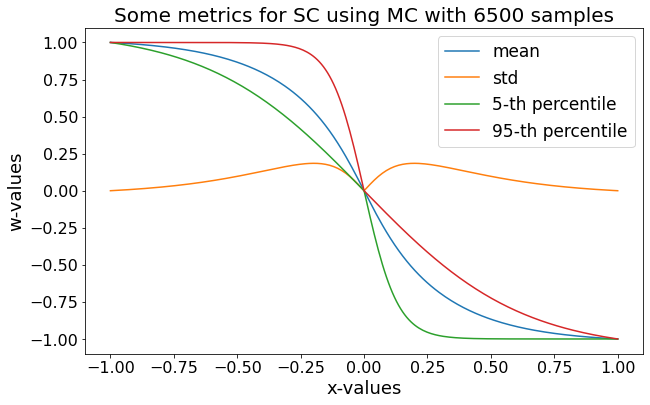

In [4]:
# plots
plt.figure(figsize=(10,6))

# appearance of plot
plt.title(f'Some metrics for SC using MC with {mc_ord} samples', fontsize=20)
plt.xlabel('x-values', fontsize=18);
plt.ylabel('w-values', fontsize=18);
plt.tick_params('both', labelsize=16);

plt.plot(x_vals, mean, label='mean');
plt.plot(x_vals, std, label='std');
plt.plot(x_vals, perc5, label='5-th percentile ');
plt.plot(x_vals, perc95, label='95-th percentile');

plt.legend(fontsize=17);

Actual x-value used 0.19999999999999996


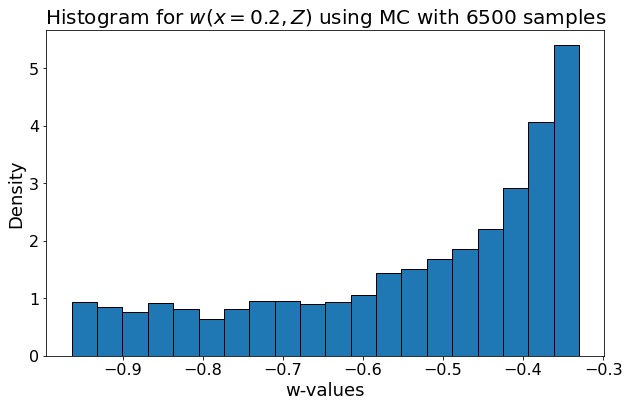

In [5]:
# histogram NOTE if x_vals is redefined somewhere else this can break
index = np.argmin(abs(x_vals-0.2))
print(f'Actual x-value used {x_vals[index]}')

plt.figure(figsize=(10,6))

# appearance of plot
plt.title(f'Histogram for $w(x=0.2, Z)$ using MC with {mc_ord} samples', fontsize=20)
plt.xlabel('w-values', fontsize=18);
plt.ylabel('Density', fontsize=18);
plt.tick_params('both', labelsize=16);

plt.hist(results_flip[index], bins=20, edgecolor='black', density=True);

### Bootstrap CI's
------

In [ ]:
toppiefloppiegrens = 0.01

mc_ord = 5000
increment_size = 500

# Nodes in x-direction/ CC-nodes
N, M = 251, 33

BS_samples = 100

# init class
SC = Stoch_Collocation()

max_CI_length = toppiefloppiegrens+1

while max_CI_length > toppiefloppiegrens:

    # number of MC samples
    mc_ord += increment_size

    # MC values for kappa
    mc_Z_vals = np.random.rand(mc_ord)*0.3+0.05
    # init result list
    results = [[] for x in mc_Z_vals]

    # get results
    for i, kappa in enumerate(mc_Z_vals):
        results[i] = SC.stoch_colloctation(N, M, kappa)

    # transpose for ease of use
    results_flip = np.array(results).T

    max_CI_length = 0
 
    for i in range(N):
        data = results_flip[i]
        CI_mean = bootstrap_CI(BS_samples, data, np.mean)
        CI_std = bootstrap_CI(BS_samples, data, np.std)
        #CI_95perc = bootstrap_CI(BS_samples, data, np.percentile, args=[95])
        #CI_5perc = bootstrap_CI(BS_samples, data, np.percentile, args=[5])

        for CI in [CI_mean, CI_std]:
            if CI[1] - CI[0] > max_CI_length:
                max_CI_length = CI[1] - CI[0]

print('Max CI len :', max_CI_length, 'with #', mc_ord, 'MC samples')
if False:
    print('95% Bootstrap-CI for mean:', CI_mean)
    print('95% Bootstrap-CI for std:', CI_std)
    print('95% Bootstrap-CI for 95th percentile:', CI_95perc)
    print('95% Bootstrap-CI for 5th percentile:', CI_5perc)

In [6]:
mc_ord = 50000

# Nodes in x-direction/ CC-nodes
N, M = 251, 33

BS_samples = 100

# init class
SC = Stoch_Collocation()

# MC values for kappa
mc_Z_vals = np.random.rand(mc_ord)*0.3+0.05
# init result list
results = [[] for x in mc_Z_vals]

# get results
for i, kappa in enumerate(mc_Z_vals):
    results[i] = SC.stoch_colloctation(N, M, kappa)

# transpose for ease of use
results_flip = np.array(results).T

max_CI_length = 0

for i in range(N):
    data = results_flip[i]
    CI_mean = bootstrap_CI(BS_samples, data, np.mean)
    CI_std = bootstrap_CI(BS_samples, data, np.std)
    CI_95perc = bootstrap_CI(BS_samples, data, np.percentile, args=[95])
    CI_5perc = bootstrap_CI(BS_samples, data, np.percentile, args=[5])

    for CI in [CI_mean, CI_std, CI_95perc, CI_5perc]:
        if CI[1] - CI[0] > max_CI_length:
            max_CI_length = CI[1] - CI[0]

print('Max CI len :', max_CI_length, 'with #', mc_ord, 'MC samples')

Max CI len : 0.007817524239254414 with # 50000 MC samples


### Some questionable error analysis
-----

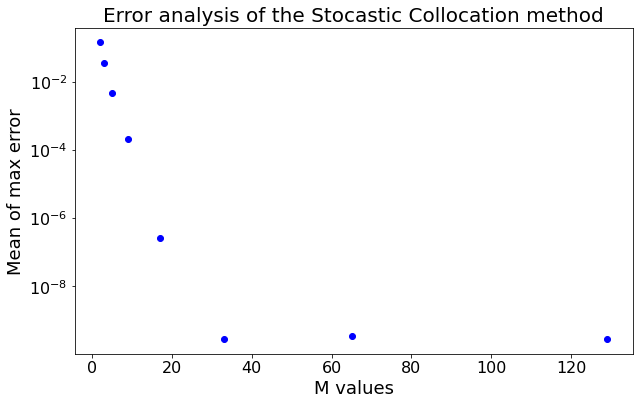

In [22]:
# Computes a mean of max error type of norm
# NOTE: System solver has 10^(-8) as tollerance by default -> changed to 10**(-12) to see if convergence goes beyond this

# From this it can be seen that around M = 33 gives good results not much more can be expected by only increasing M
# Also by testing various values of N it seems to be stable from around N = 250 with error around 10**(-10)

##### see size of error for different values of M #####

# number of grid points
N = 500

# values of M to test note these are nested for a nice speedup
M_vals = [2**n + 1 for n in range(8)]
# values of kappa for which to test
kappa_vals = np.linspace(0.05, 0.35, 10)

# init class
SC = Stoch_Collocation()
# init list to store errors
Error_list = []
# Test
for M in M_vals:
    # reset error for current M val
    error = 0
    # get errors for each kappa val
    for kappa in kappa_vals:
        approx = np.array(SC.stoch_colloctation(N, M, kappa, res_tol = 10**(-12), update_tol=10**(-12)))
        real = System_solver(N, [-1, 1], [1, -1], kappa, res_tol = 10**(-12), update_tol=10**(-12))
        error += np.linalg.norm(real - approx, np.inf)

    # append mean of max error
    Error_list.append(error/10)

plt.figure(figsize=(10,6))
plt.semilogy(M_vals, Error_list, 'bo');
plt.title('Error analysis of the Stocastic Collocation method', fontsize=20)
plt.xlabel('M values', fontsize=18);
plt.ylabel('Mean of max error', fontsize=18);
plt.tick_params('both', labelsize=16);


### Some more questionable code
------

In [14]:
# NOTE the data points are not independent
# init class
SC = Stoch_Collocation()

# some parameters
N_Trials = 10

# number of MC samples
mc_ord= 100000
inter_vals = range(2500, mc_ord+1, 2500)
# Nodes in x-direction/ CC-nodes
N, M = 251, 5
x_vals = np.linspace(-1, 1, N)

# get intermediate mean values for diff MC sample sizes
means = [np.zeros(N) for L in inter_vals]

for trial in range(N_Trials):

    # MC values for kappa
    mc_Z_vals = np.random.rand(mc_ord)*0.3+0.05

    # init result list
    results = [[] for x in mc_Z_vals]

    # get results
    for i, kappa in enumerate(mc_Z_vals):
        results[i] = SC.stoch_colloctation(N, M, kappa)

    # transpose for ease of use
    results_flip = np.array(results).T

    for j, L in enumerate(inter_vals):
        # calculate statistics
        means[j] += np.mean(results_flip[:,0:L], axis=1)

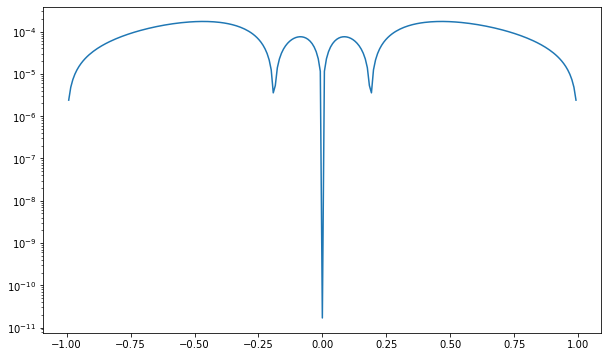

In [16]:
# plot showing the absolute error of the `exact` mean and the approximation
true_mean = np.array(SC.Lagrange_func_int(M, N))

plt.figure(figsize=(10,6))
plt.semilogy(x_vals[1:250], abs(true_mean[1:250]-mean[1:250]));

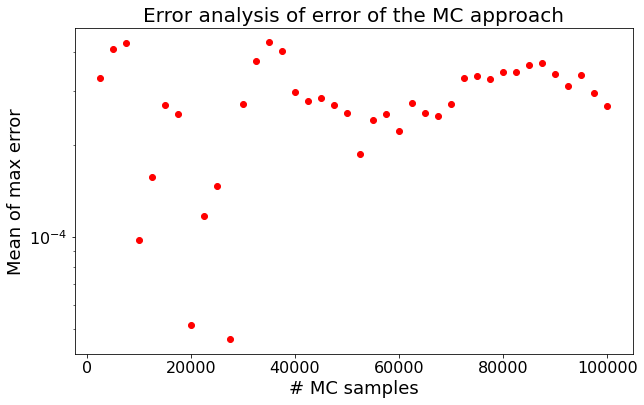

In [15]:
errors = []
# get true mean
true_mean = SC.Lagrange_func_int(M, N)

for i, L in enumerate(inter_vals):
    errors.append(np.linalg.norm(means[i]/N_Trials-np.array(true_mean),np.inf))

plt.figure(figsize=(10,6))
plt.semilogy(inter_vals, errors, 'ro');
plt.title('Error analysis of error of the MC approach', fontsize=20)
plt.xlabel('# MC samples', fontsize=18);
plt.ylabel('Mean of max error', fontsize=18);
plt.tick_params('both', labelsize=16);

### TESTS - Ignore
-------

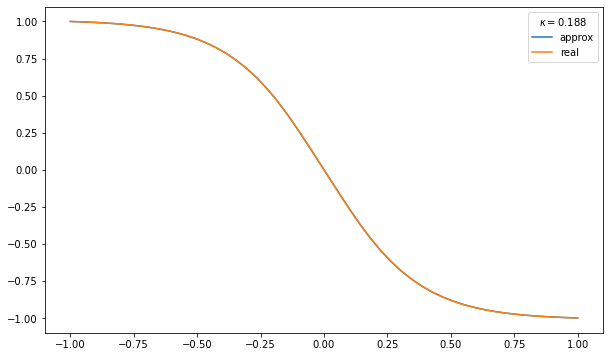

In [8]:
# general test for approximation results

N, M = 50, 2**2 + 1
x_vals = np.linspace(-1, 1, N)
x_vals2 = np.linspace(-1, 1, 250)

kappa = np.random.rand()*0.3+0.05
SC = Stoch_Collocation()

approx = SC.stoch_colloctation(N, M, kappa)
real = System_solver(250, [-1, 1], [1, -1], kappa)

plt.figure(figsize=(10,6))
plt.plot(x_vals, approx, label='approx');
plt.plot(x_vals2, real, label='real');

plt.legend(title=f'$\kappa = {round(kappa,3)}$');

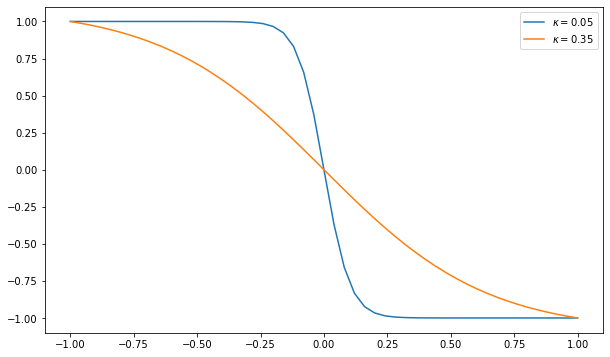

In [8]:
# test for newton solver
N = 51
a = System_solver(N, [-1, 1], [1, -1], 0.05)
b = System_solver(N, [-1, 1], [1, -1], 0.35)

plt.figure(figsize=(10,6))
plt.plot(np.linspace(-1, 1, N), a, label='$\kappa = 0.05$');
plt.plot(np.linspace(-1, 1, N), b, label='$\kappa = 0.35$');

plt.legend();

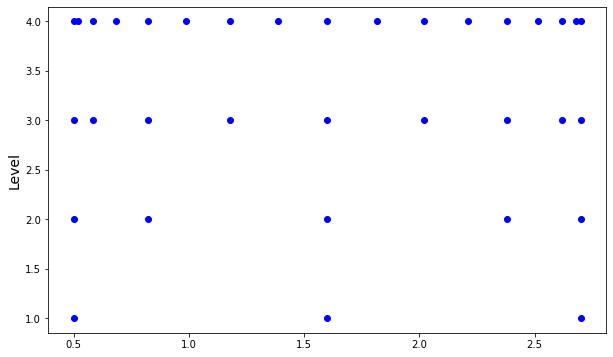

In [29]:
# Clenshaw Curtis nodes test
plt.figure(figsize=(10,6))
plt.ylabel('Level', fontsize=14)
for M in range(1, 5):
    nodes = Clenshaw_Curtis(2**M+1, domain=[.5, 2.7])
    y = [M]*(2**M+1)
    plt.plot(nodes, y, 'bo');

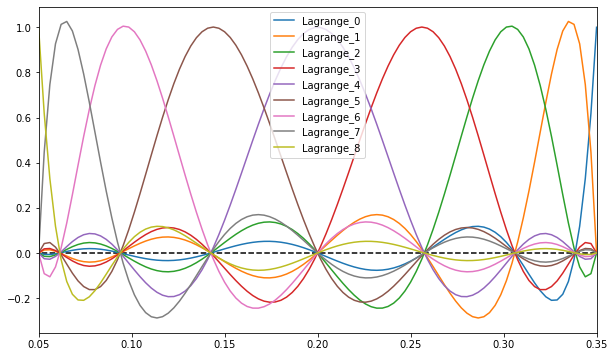

In [27]:
# Lagrange polynomial test
M = 9

Z_vals = Clenshaw_Curtis(M, [0.05, 0.35])

results = [[] for i in range(M)]
for k in range(M):
    x_vals = np.linspace(0.05, 0.35, 100)
    for Z in x_vals:
        results[k].append(Lagrange(Z, Z_vals, k))

plt.figure(figsize=(10,6))
plt.xlim(0.05, 0.35)
plt.hlines(0, -1, 1, color='black', ls='--');
for k in range(M):
    plt.plot(x_vals, results[k], label=f'Lagrange_{k}');

plt.legend();